<a href="https://colab.research.google.com/github/divyakumar95/emotionAnalysis/blob/main/ML_CA_02_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Sources

* https://www.kaggle.com/parulpandey/emotion-dataset/download
* https://drive.google.com/drive/u/1/folders/1oRZNWkOLESPNiW-nLZrh-wNe2G7eS9ln

Text to Number conversion Sources

* https://thecleverprogrammer.com/2021/04/17/convert-text-into-numerical-data-using-python/

Importing Data - Source code

* https://colab.research.google.com/notebooks/io.ipynb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

Data Files path

In [3]:
Drive_data = '/content/drive/MyDrive/Text_data/training.csv'
local_data = 'Data/training.csv'

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

In [7]:
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
colors = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(colors))
plt.rcParams['figure.figsize'] = 12, 8

In [8]:
import os 
if os.path.exists(Drive_data):
    data = pd.read_csv(Drive_data)
else:
    data = pd.read_csv(local_data)

In [9]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
data['description'] = data['label'].map(labels_dict )
data.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [10]:
data['description'].value_counts(normalize=True)

joy         0.335125
sadness     0.291625
anger       0.134937
fear        0.121063
love        0.081500
surprise    0.035750
Name: description, dtype: float64

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words='english')

In [12]:
new_vect = vect.fit_transform(data['text'].values)
print(vect.get_feature_names()[:10])

['ability', 'able', 'absolutely', 'abused', 'accept', 'acceptable', 'accepted', 'accomplished', 'ache', 'aching']


In [13]:
X = new_vect.toarray()
y = data['label']

In [14]:
print("X Shape",X.shape)
print("Y Shape",y.shape)

X Shape (16000, 1500)
Y Shape (16000,)


In [15]:
from collections import Counter
Counter(y)

Counter({0: 4666, 3: 2159, 2: 1304, 5: 572, 4: 1937, 1: 5362})

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

sample = RandomOverSampler(sampling_strategy='minority')
#sample = RandomUnderSampler(replacement=True)
 
# fit and apply the transform
X_over, y_over = SMOTE().fit_resample(X, y)

print(Counter(y_over))

In [25]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier # decision tee algorithm for classification
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
import pickle
import timeit, time

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [21]:
def base_models():
  models = dict()
  models['lr'] = LogisticRegression(solver='lbfgs', max_iter=500)
  models['svm_Linear'] = SVC(kernel='linear')
  models['svm_Polly'] = SVC(kernel='poly')
  models['svm_RBF'] = SVC(kernel='rbf')
  models['svm_Sigmoid'] = SVC(kernel='sigmoid')
  models['dt_ent'] = DecisionTreeClassifier(criterion='entropy')
  models['dt_gini'] = DecisionTreeClassifier(criterion='gini')
  models['rf'] = RandomForestClassifier(n_estimators=130, criterion='entropy')
  return models

Monte carlo runs

In [22]:
def evaluate_model_Multi(model, X, y, mc):
  acc = [] ### Blank vector
  f = []
  prec = []
  rec = []
  single = timeit.default_timer()
  for i in range(mc):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=i)# split dataset
    dt = model.fit(X_train,y_train) # fit the model
    YPred = dt.predict(X_test) # predict
    a = accuracy_score(y_test,YPred) # compute accuracy
    acc.append(a) # append accuracy
    f1 = f1_score(y_test, YPred, average='weighted')
    precision = precision_score(y_test, YPred, average='weighted')
    recall = recall_score(y_test, YPred, average='weighted')
    f.append(f1)
    prec.append(precision)
    rec.append(recall)
    timed = timeit.default_timer() - single
    return np.mean(acc), dt, np.mean(recall), np.mean(prec),np.mean(f), np.mean(timed)

In [24]:
from numpy import mean, std
import warnings
warnings.filterwarnings("ignore")
# get the models to evaluate
models = base_models()
# evaluate the models and store results
Single_results, Single_names = list(), list()
Single_run = 1
start_single = timeit.default_timer()
for name, model in models.items():
	scores, mod, prec, recall,fscore, timed = evaluate_model_Multi(model,X,y,Single_run) #,X_over,y_over)#, X, y)
	Single_results.append(scores)
	Single_names.append(name)
	#filename = 'Models/'+name+'.pkl'
	#pickle.dump(mod, open(filename, 'wb'))
	print(name,'-- accuracy:', mean(scores), '-- Deviation',std(scores),'-- Precision ', mean(prec),'-- Recall', mean(recall),'-- Fscore:', mean(fscore))
print('Total time for single run to check models: ', timeit.default_timer() - start_single) 

lr -- accuracy: 0.87125 -- Deviation 0.0 -- Precision  0.87125 -- Recall 0.8712349502909648 -- Fscore: 0.8704569731892718
svm_Linear -- accuracy: 0.860625 -- Deviation 0.0 -- Precision  0.860625 -- Recall 0.8612831942688906 -- Fscore: 0.8602931033837103
svm_Polly -- accuracy: 0.61 -- Deviation 0.0 -- Precision  0.61 -- Recall 0.6806324645530768 -- Fscore: 0.5430535121814706
svm_RBF -- accuracy: 0.836875 -- Deviation 0.0 -- Precision  0.836875 -- Recall 0.8445274107306971 -- Fscore: 0.8326791890241033
svm_Sigmoid -- accuracy: 0.775 -- Deviation 0.0 -- Precision  0.775 -- Recall 0.7790720035409707 -- Fscore: 0.7738120028948207
dt_ent -- accuracy: 0.8278125 -- Deviation 0.0 -- Precision  0.8278125 -- Recall 0.8302841071630145 -- Fscore: 0.8275379273407616
dt_gini -- accuracy: 0.8134375 -- Deviation 0.0 -- Precision  0.8134375 -- Recall 0.8172844337412661 -- Fscore: 0.812884332772516
rf -- accuracy: 0.8684375 -- Deviation 0.0 -- Precision  0.8684375 -- Recall 0.8698934978526546 -- Fscore: 

In [29]:
def get_stacking():
	# define the base models: level0 models
	level0 = list()
	level0.append(('lr', LogisticRegression(solver='lbfgs', max_iter=500)))
	level0.append(('Rand', RandomForestClassifier(n_estimators=130, criterion='entropy')))
	#level0.append(('svm', SVC(kernel='linear')))
	# define meta learner model: level 1
	level1 = LogisticRegression(solver='lbfgs', max_iter=500)
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

In [30]:
def ensemble_model():
  lr = LogisticRegression(solver='lbfgs', max_iter=500)               #Base model
  rf = RandomForestClassifier(n_estimators=130, criterion='entropy')    #Base model
  models = dict()
  models['lr'] = LogisticRegression(solver='lbfgs', max_iter=500)
  models['rf'] = RandomForestClassifier(n_estimators=130, criterion='entropy')
  models['bagging_Lr'] = BaggingClassifier(base_estimator=lr, n_estimators=50, max_samples=0.8, max_features=0.8)
  models['bagging_Rf'] = BaggingClassifier(base_estimator=rf, n_estimators=50, max_samples=0.8, max_features=0.8)
  models['adaboost_lr'] = AdaBoostClassifier(base_estimator=lr, n_estimators=800)
  #models['adaboost_RF'] = AdaBoostClassifier(base_estimator=rf, n_estimators=800)
  models['stacking'] = get_stacking()
  return models

In [31]:
from numpy import mean, std
import warnings
warnings.filterwarnings("ignore")

# get the models to evaluate
models = ensemble_model()
# evaluate the models and store results
mul_results, mul_names = list(), list()
number_of_runs = 100
start_multi = time.time()
for name, model in models.items():
	scores, mod, prec, recall, fscore, timed = evaluate_model_Multi(model, X, y, number_of_runs) #,X_over,y_over)#, X, y)
	mul_results.append(scores)
	mul_names.append(name)
	filename = 'Models/'+name+'.pkl'
	pickle.dump(mod, open(filename, 'wb'))
	print(name,'-- accuracy:', mean(scores), '-- Deviation',std(scores),'-- Precision ', mean(prec),'-- Recall', mean(recall),'-- Fscore:', mean(fscore))
print('Total time to run 100 Monte carlo runs: ', time.time() - start_multi) 

lr -- accuracy: 0.87125 -- Deviation 0.0 -- Precision  0.87125 -- Recall 0.8712349502909648 -- Fscore: 0.8704569731892718
rf -- accuracy: 0.8703125 -- Deviation 0.0 -- Precision  0.8703125 -- Recall 0.8716903166135518 -- Fscore: 0.8707404767321141
bagging_Lr -- accuracy: 0.8690625 -- Deviation 0.0 -- Precision  0.8690625 -- Recall 0.8692926326179895 -- Fscore: 0.8672374902152149
bagging_Rf -- accuracy: 0.87 -- Deviation 0.0 -- Precision  0.87 -- Recall 0.8699671548035854 -- Fscore: 0.8699022623623782
adaboost_lr -- accuracy: 0.7890625 -- Deviation 0.0 -- Precision  0.7890625 -- Recall 0.8070980370125586 -- Fscore: 0.7800443208843663
stacking -- accuracy: 0.875625 -- Deviation 0.0 -- Precision  0.875625 -- Recall 0.8751517538822537 -- Fscore: 0.875156401765199
Total time to run 100 Monte carlo runs:  1995.289818763733


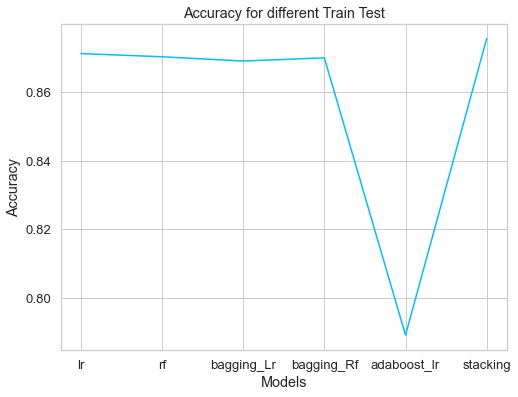

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(mul_names, mul_results)
plt.ylabel('Accuracy'); plt.xlabel('Models'); plt.title('Accuracy for different Train Test');
plt.show()

In [35]:
def evaluate_model_cross(model, X, y):
	cv = 4
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
	return scores

In [36]:
from numpy import mean, std
# get the models to evaluate
models = ensemble_model()
# evaluate the models and store results
cross_results, cross_names = list(), list()
for name, model in models.items():
	scores = evaluate_model_cross(model, X, y)
	cross_results.append(scores)
	cross_names.append(name)
	#filename = 'Models/'+name+'_cv.pkl'
	#pickle.dump(model, open(filename, 'wb'))
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.873 (0.007)
>rf 0.866 (0.005)
>bagging_Lr 0.873 (0.007)
>bagging_Rf 0.867 (0.006)
>adaboost_lr 0.789 (0.007)
>stacking 0.876 (0.005)


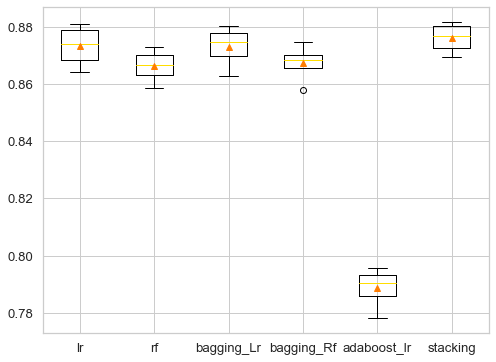

In [38]:
plt.figure(figsize=(8, 6))
plt.boxplot(cross_results, labels=cross_names, showmeans=True)
plt.show()

In [40]:
import numpy as np

tsize = [0.2,0.3,0.4,0.5,0.6]
tsize_acc = {}
for i in tsize:
    acc = []
    for j in range(20):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=i, random_state = j)
        mod = LogisticRegression(solver='lbfgs', max_iter=500) 
        mod.fit(X_train, y_train)
        mod_pred = mod.predict(X_test)
        accuracy = accuracy_score(y_test,mod_pred)
        acc.append(accuracy)
    tsize_acc.update({i:np.mean(acc)})
print(tsize_acc)

{0.2: 0.8745156250000001, 0.3: 0.8733333333333334, 0.4: 0.87096875, 0.5: 0.86770625, 0.6: 0.8628020833333332}


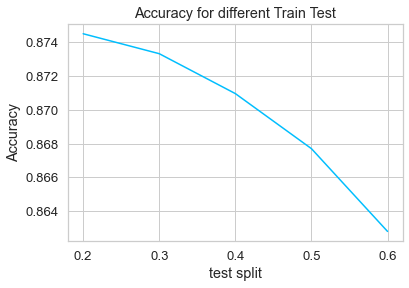

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(*zip(*sorted(tsize_acc.items())))
plt.ylabel('Accuracy'); plt.xlabel('test split'); plt.title('Accuracy for different Train Test');
plt.show()

In [43]:
num_est = np.arange(2,16,4)
lr_cv_mean = []
lr_cv_std = []
for n_est in num_est:
    lr = LogisticRegression(solver='lbfgs', max_iter=500) 
    scores = cross_val_score(lr, X, y, cv=n_est, scoring='accuracy')
    lr_cv_mean.append(scores.mean())
    lr_cv_std.append(scores.std())

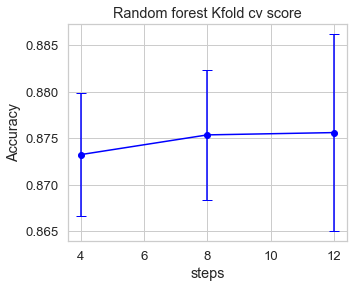

In [44]:
plt.figure(figsize=(5, 4))
plt.errorbar(num_est, lr_cv_mean, yerr=lr_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('Random forest Kfold cv score');
plt.show()

In [45]:
num_est = np.arange(10,150,10)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    mod = RandomForestClassifier(n_estimators = n_est, criterion='entropy')
    mod.fit(X_train, y_train)
    mod_pred = mod.predict(X_test)
    accuracy = accuracy_score(y_test,mod_pred)
    bg_clf_cv_mean.append(accuracy.mean())
    bg_clf_cv_std.append(accuracy.std())

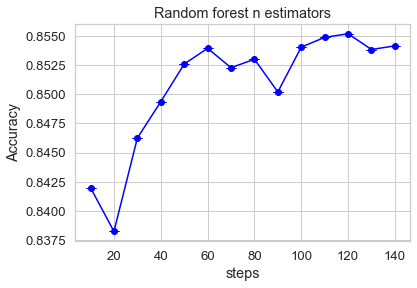

In [46]:
plt.figure(figsize=(6, 4))
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('Random forest n estimators');
plt.show()

In [47]:
lr = LogisticRegression(solver='lbfgs', max_iter=500) 

num_ada_est = np.arange(100,1000,100)
ada_clf_cv_mean = []
ada_clf_cv_std = []
for n_est in num_ada_est:
    mod = AdaBoostClassifier(base_estimator=lr, n_estimators=n_est)
    mod.fit(X_train, y_train)
    mod_pred = mod.predict(X_test)
    accuracy = accuracy_score(y_test,mod_pred)
    ada_clf_cv_mean.append(accuracy.mean())
    ada_clf_cv_std.append(accuracy.std())

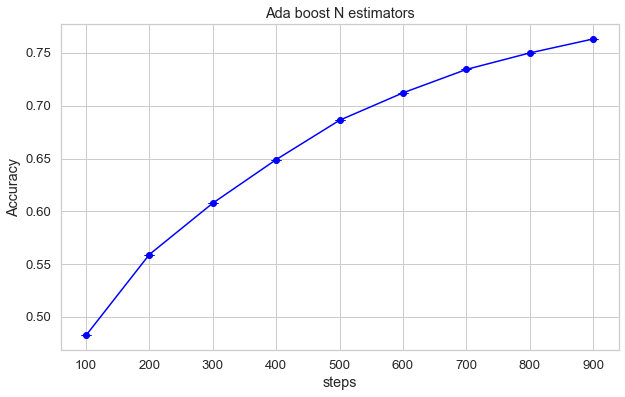

In [48]:
plt.figure(figsize=(10, 6))
plt.errorbar(num_ada_est, ada_clf_cv_mean, yerr=ada_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('Ada boost N estimators');
plt.show()